## Imports

In [9]:
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from bbtoolkit.models.bb.neural_generators import MTLGenerator,\
    HDGenerator,\
    TCGenerator,\
    GCGenerator, GCMap,\
    PCGenerator
import configparser
from bbtoolkit.utils.datautils.configparser import EvalConfigParser
import numpy as np
from bbtoolkit.environment import Environment
from bbtoolkit.environment.builders import EnvironmentBuilder

## Create environment

In [10]:
min_xy, max_xy = -10, 10 # create the box of size 20x20
min_train_x, max_train_x, min_train_y, max_train_y = -10, 10, -10, 10 # create the training area of size 20x10
res = 0.3 # set grid resolution

builder = EnvironmentBuilder(
    min_xy,
    max_xy,
    (min_train_x, min_train_y),
    (max_train_x, max_train_y),
    res=res
)

In [11]:
from bbtoolkit.structures.geometry import Texture, TexturedPolygon
from shapely.geometry import Polygon, Point

builder.add_wall(
    TexturedPolygon(
        Polygon(
            shell=[
                Point(-10, 10),
                Point(10, 10),
                Point(10, 9),
                Point(-10, 9)
            ],
        ),
        texture=Texture(
            1,
            '#16745B',
            'north_wall'
        )
    ),
    TexturedPolygon(
        Polygon(
            shell=[
                Point(-10, 9),
                Point(-10, -9),
                Point(-9, -9),
                Point(-9, 9)
            ],
        ),
        texture=Texture(
            2,
            '#16745B',
            'western_wall'
        )
    ),
    TexturedPolygon(
        Polygon(
            shell=[
                Point(-10, -10),
                Point(10, -10),
                Point(10, -9),
                Point(-10, -9)
            ],
        ),
        texture=Texture(
            3,
            '#16745B',
            'south_wall'
        )
    ),
    TexturedPolygon(
        Polygon(
            shell=[
                Point(10, 9),
                Point(10, -9),
                Point(9, -9),
                Point(9, 9)
            ],
        ),
        texture=Texture(
            4,
            '#16745B',
            'eastern_wall'
        )
    ),
    TexturedPolygon(
        Polygon(
            shell=[
                Point(-5, 5),
                Point(5, 5),
                Point(5, 4),
                Point(-5, 4)
            ],
        ),
        texture=Texture(
            5,
            '#16745B',
            'inserted_wall'
        )
    )
)

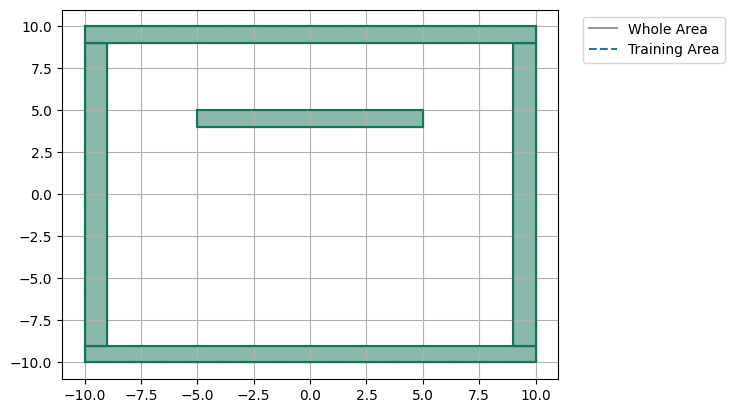

In [12]:
_ =  builder.plot()

In [13]:
from bbtoolkit.environment.compilers import EnvironmentCompiler


compiler = EnvironmentCompiler(builder)
env = compiler.compile()

In [14]:
env.save('../data/envs/inserted_wall_environment.pkl')

In [10]:
env = Environment.load('../data/envs/inserted_wall_environment.pkl')

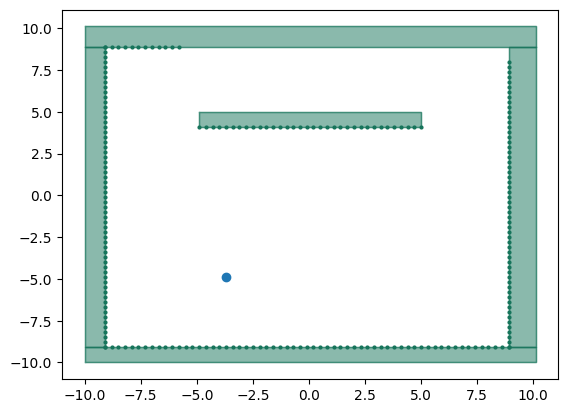

In [15]:
from bbtoolkit.utils.viz import plot_polygon
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
position = 1000 # the position of the agent (visible area has dimensionality n_positions x 2)
for i, obj in enumerate(env.objects + env.walls):
    plot_polygon(obj.polygon, ax=ax, alpha=0.5, linewidth=1)
    ax.plot(
        obj.visible_parts[position, :, 0],
        obj.visible_parts[position, :, 1],
        'o',
        color=obj.polygon.texture.color,
        markersize=2
    )

ax.plot(
    env.params.coords[position, 0],
    env.params.coords[position, 1],
    'o'
)

## MTL weights

In [16]:
mtl_cfg = '../cfg/cells/mtl_cells.ini'
config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
config.read(mtl_cfg)

space_section = config['Space']
res = space_section.eval('res')
r_max = space_section.eval('r_max')

polargrid_section = config['PolarGrid']
polar_dist_res = polargrid_section.eval('polar_dist_res')
polar_ang_res = polargrid_section.eval('polar_ang_res', locals=dict(pi=np.pi))
h_sig = polargrid_section.eval('sigma_hill')


gen = MTLGenerator(
    r_max, h_sig, polar_dist_res, polar_ang_res, env
)
gen.save('../data/generators/mtl_gen.pkl')
weights = gen.generate()

In [ ]:
weights.connection_map

,h,bvc,pr
h,1,1,1
bvc,1,1,1
pr,1,1,1


In [17]:
weights.save('../data/weights/mtl_weights_inserted_wall.pkl')

## Head Direction Weights

In [18]:
config_path = '../cfg/cells/hd_cells.ini'
config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
config.read(config_path)

neurons_cfg = config['Neurons']
n_hd = neurons_cfg.eval('n_neurons')
amp_max = neurons_cfg.eval('max_amplitude')
sig_scaled = neurons_cfg.eval('sigma', locals={'pi': np.pi})

training_cfg = config['Training']
n_steps = training_cfg.eval('n_steps')
dt = training_cfg.eval('dt')
log_size = training_cfg.eval('log_size')
decay = training_cfg.eval('decay')

weights = HDGenerator(
    n_hd,
    amp_max,
    sig_scaled,
    n_steps,
    dt,
    log_size,
    decay
).generate()

In [ ]:
weights.connection_map

,rot,hd
rot,1,0
hd,0,1


In [19]:
weights.save('../data/weights/hd_weights_inserted_wall.pkl')

## Transformation circuit

In [20]:
hd_config_path = '../cfg/cells/hd_cells.ini'
hd_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
hd_config.read(hd_config_path)

mtl_config_path = '../cfg/cells/mtl_cells.ini'
mtl_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
mtl_config.read(mtl_config_path)

tr_config_path = '../cfg/cells/transformation_circuit.ini'
tr_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
tr_config.read(tr_config_path)

r_max = mtl_config['Space'].eval('r_max')

mtl_grid_cfg = mtl_config['PolarGrid']
n_radial_points = mtl_grid_cfg.eval('n_radial_points')
polar_dist_res = mtl_grid_cfg.eval('polar_dist_res')
polar_ang_res = mtl_grid_cfg.eval('polar_ang_res', locals={'pi': np.pi})
h_sig = mtl_grid_cfg.eval('sigma_hill')

tr_space_cfg = tr_config['Space']
tr_res = tr_space_cfg.eval('tr_res', locals={'pi': np.pi})
res = tr_space_cfg.eval('res')

n_steps = tr_config['Training'].eval('n_steps')

hd_neurons_cfg = hd_config['Neurons']
sigma_angular = hd_neurons_cfg.eval('sigma', locals={'pi': np.pi})
n_hd = hd_neurons_cfg.eval('n_neurons')


gen = TCGenerator(
    n_hd,
    tr_res,
    res,
    r_max,
    polar_dist_res,
    n_radial_points,
    polar_ang_res,
    sigma_angular,
    n_steps=n_steps
)
gen.save('../data/generators/tc_gen.pkl')
weights = gen.generate()

In [ ]:
weights.connection_map

,tr,bvc,pw,hd
tr,0,1,1,0
bvc,1,0,0,0
pw,1,0,0,0
hd,1,0,0,0


In [21]:
weights.save('../data/weights/tc_weights_inserted_wall.pkl')

## Grid Cells Firing Rate Map

In [22]:
cfg_path = '../cfg/cells/grid_cells.ini'
config = EvalConfigParser()
config.read(cfg_path)

space_config = config['Space']
n_mod = space_config.eval('n_mod')
n_per_mod = space_config.eval('n_per_mod')

neurons_config = config['Neurons']
f_mods = neurons_config.eval('f_mods', locals={'pi': np.pi})
fac = neurons_config.eval('FAC')
r_size = neurons_config.eval('r_size')
orientations = neurons_config.eval('orientations', locals={'pi': np.pi})


frmap = GCGenerator(
    env,
    n_mod,
    n_per_mod,
    f_mods,
    fac,
    r_size,
    orientations
).generate()

In [23]:
frmap.save('../data/weights/gc_map_inserted_wall.pkl')

## Place Cells

In [24]:
gc_cfg_path = '../cfg/cells/grid_cells.ini'
gc_config = EvalConfigParser()
gc_config.read(gc_cfg_path)

pc_cfg_path = '../cfg/cells/place_cells.ini'
pc_config = EvalConfigParser()
pc_config.read(pc_cfg_path)

gc_space_config = gc_config['Space']
n_mod = gc_space_config.eval('n_mod')
n_per_mod = gc_space_config.eval('n_per_mod')

pc_space_config = pc_config['Space']
res = pc_space_config.eval('res')
x_max = pc_space_config.eval('x_max')
y_max = pc_space_config.eval('y_max')

weights = PCGenerator(
    env,
    n_mod=7,
    n_per_mod=100,
    gc_map=GCMap.load('../data/weights/gc_map.pkl')
).generate()

In [25]:
gc_map = GCMap.load('../data/weights/gc_map.pkl')

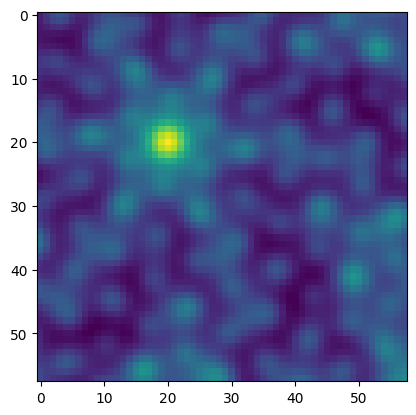

In [26]:
import matplotlib.pyplot as plt

plt.imshow(np.reshape((weights.gc.to.h)@np.reshape(gc_map.fr[20, 20], (-1, 1)), (58, 58)))

In [ ]:
weights.connection_map

,gc,h
gc,0,1


In [27]:
weights.save('../data/weights/pc_weights_inserted_wall.pkl')